In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:

%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [3]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [4]:
IMGWIDTH = 128

class Config():
    training_dir = "/data/tam/kaggle/train_imgs/"
    testing_dir = "/data/tam/kaggle/test_imgs/"
    train_batch_size = 32
    train_number_epochs = 100

In [5]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
#         img0 = img0.convert("L")
#         img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [6]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)


In [ ]:
folder_dataset

In [ ]:
random.choice(folder_dataset)[0]
# random.choice(folder_dataset)[1]

In [7]:

siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((IMGWIDTH,IMGWIDTH)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

In [ ]:
a = siamese_dataset.__getitem__(1)

In [ ]:
a[0].shape

In [ ]:

vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [8]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
#             nn.ReflectionPad2d(1),
            nn.Conv2d(3, 8, kernel_size=3,padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(kernel_size=2,stride=2),
            
            
#             nn.ReflectionPad2d(1),
            nn.Conv2d(8, 16, kernel_size=3,padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2,stride=2),


#             nn.ReflectionPad2d(1),
            nn.Conv2d(16, 32, kernel_size=3,padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2,stride=2),
            
            nn.Conv2d(32, 32, kernel_size=3,padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32, 64, kernel_size=3,padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2,stride=2),
        )

        self.fc1 = nn.Sequential(
#             nn.Linear(8*IMGWIDTH*IMGWIDTH*3, 500),
            
            nn.Linear(64*8*8, 512),

            nn.ReLU(inplace=True),

            nn.Linear(512, 256),
            nn.ReLU(inplace=True),

            nn.Linear(256, 32))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [9]:
from torchvision import transforms, datasets, models

class SiameseNetworkResnet(nn.Module):
    def __init__(self):
        super(SiameseNetworkResnet, self).__init__()
        self.model = models.resnet50(pretrained=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = torch.nn.Linear(num_ftrs, 32)


    def forward_once(self, x):
        output = self.model(x)

        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [10]:
class SiameseNetwork_Basic(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 15, kernel_size=7),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2,2)),

            nn.Conv2d(15, 45, kernel_size=6),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((4,3)),

            nn.Conv2d(45, 250, kernel_size=5),
            nn.ReLU(inplace=True),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(250,50),
            nn.ReLU(inplace=True)
            )

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [11]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [12]:

train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [13]:
# net = SiameseNetwork().cuda()
net = SiameseNetworkResnet().cuda()

criterion = ContrastiveLoss(16)
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [ ]:
from torchsummary import summary


In [ ]:
summary(net,[(3,128,128),(3,128,128)])

In [ ]:
net

In [36]:
counter = []
loss_history = [] 
iteration_number= 0

In [37]:
import time

In [ ]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        time.sleep(0.05)
#         img0, img1 , label = img0, img1 , label
        # print(img0.size())
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %100 == 0 :
            print("Epoch number {}\n iteration_number {} Current loss {}\n".format(epoch,iteration_number,loss_contrastive.item()))
            iteration_number +=100
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

Epoch number 0
 iteration_number 500 Current loss 116.56212615966797

Epoch number 0
 iteration_number 600 Current loss 72.10340881347656

Epoch number 0
 iteration_number 700 Current loss 66.46215057373047

Epoch number 0
 iteration_number 800 Current loss 71.43148803710938

Epoch number 0
 iteration_number 900 Current loss 83.02449035644531

Epoch number 0
 iteration_number 1000 Current loss 67.13737487792969

Epoch number 0
 iteration_number 1100 Current loss 56.044498443603516

Epoch number 0
 iteration_number 1200 Current loss 62.62676239013672

Epoch number 0
 iteration_number 1300 Current loss 63.706787109375

Epoch number 0
 iteration_number 1400 Current loss 77.1285400390625

Epoch number 0
 iteration_number 1500 Current loss 68.16960144042969

Epoch number 0
 iteration_number 1600 Current loss 66.33666229248047

Epoch number 0
 iteration_number 1700 Current loss 70.8116683959961

Epoch number 0
 iteration_number 1800 Current loss 82.19435119628906

Epoch number 0
 iteration_n

In [15]:
# torch.save(net.state_dict(), "siamese.pth")
# net.load_state_dict(torch.load("siamese2.pth"))
net.load_state_dict(torch.load("siameseResnet.pth"))


<All keys matched successfully>

In [ ]:
# torch.save(net.state_dict(), "siamese.pth")
# torch.save(net.state_dict(), "siameseResnet.pth")


In [ ]:
show_plot(counter,loss_history)

tensor([[0.]])


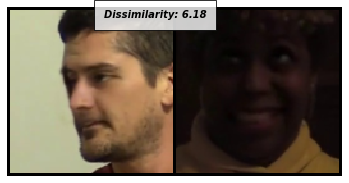

tensor([[0.]])


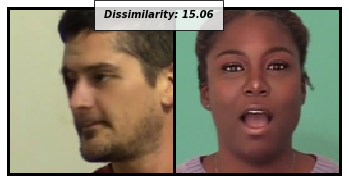

tensor([[1.]])


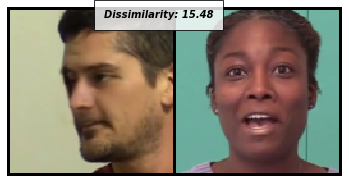

tensor([[0.]])


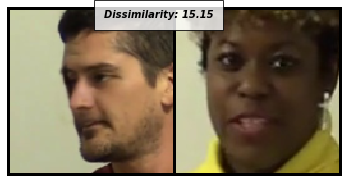

tensor([[0.]])


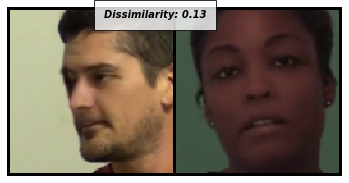

tensor([[0.]])


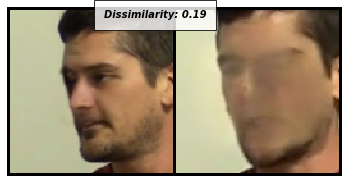

tensor([[0.]])


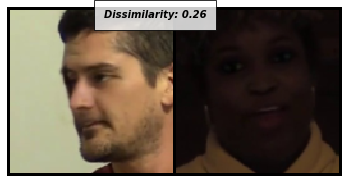

tensor([[1.]])


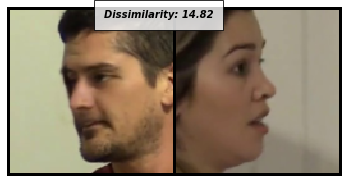

tensor([[1.]])


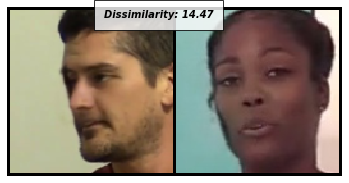

tensor([[1.]])


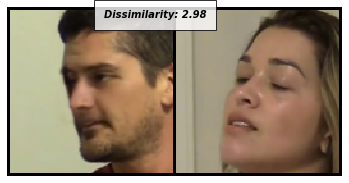

In [16]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((128,128)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
#     output1,output2 = net(Variable(x0),Variable(x1))

    euclidean_distance = F.pairwise_distance(output1, output2)
    print(label2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

In [20]:
dataiter = iter(test_dataloader)

x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
#     output1,output2 = net(Variable(x0),Variable(x1))

    euclidean_distance = F.pairwise_distance(output1, output2)
    print(label2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

tensor([[0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])


ValueError: only one element tensors can be converted to Python scalars

In [24]:
x0[0].

torch.Size([3, 128, 128])

In [17]:
test_folder_dataset = dset.ImageFolder("/data/tam/kaggle/test_imgs/")
test_siamese_dataset = SiameseNetworkDataset(imageFolderDataset=test_folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((IMGWIDTH,IMGWIDTH)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(test_siamese_dataset,
                        shuffle=True,
                        num_workers=64,
                        batch_size=Config.train_batch_size)

In [ ]:
img0, img1 , label  = test_siamese_dataset.__getitem__(1)

In [ ]:
img0, img1 , label = img0.unsqueeze(0).cuda(), img1.unsqueeze(0).cuda() , label.cuda()


In [ ]:
torch.ifft2(img0)

In [ ]:
output1,output2 = net(img0,img1)


In [ ]:
output1

In [18]:
test_loss = 0
for i, data in enumerate(test_dataloader,0):
    img0, img1 , label = data
    img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
#         img0, img1 , label = img0, img1 , label
    # print(img0.size())
    optimizer.zero_grad()
    output1,output2 = net(img0,img1)
    loss_contrastive = criterion(output1,output2,label)
    test_loss +=loss_contrastive.item()
    print(i)
    print(loss_contrastive.item())

0
96.07228088378906
1
66.36443328857422
2
85.4935073852539
3
61.02050018310547
4
84.43505096435547
5
77.91853332519531
6
60.083160400390625
7
54.856300354003906
8
64.11602020263672
9
135.01156616210938
10
83.0103988647461
11
80.544677734375
12
67.08688354492188
13
109.49787139892578
14
67.56517791748047
15
70.12056732177734
16
104.45205688476562
17
78.90354919433594
18
80.21731567382812
19
76.67550659179688
20
75.2930908203125
21
91.9394760131836
22
74.2266845703125
23
80.03604125976562
24
75.22673034667969
25
87.83207702636719
26
84.81025695800781
27
114.27589416503906
28
81.37512969970703
29
90.19184875488281
30
72.72663879394531
31
78.85604858398438
32
75.65023803710938
33
65.67400360107422
34
77.64064025878906
35
62.18566131591797
36
79.08168029785156
37
83.06205749511719
38
77.36817169189453
39
75.88560485839844
40
95.44793701171875
41
93.57951354980469
42
83.09140014648438
43
109.01271057128906
44
97.7161865234375
45
55.31820297241211
46
67.03514862060547
47
75.21129608154297
48


In [ ]:
test_loss

In [19]:
test_loss

10445.231086730957

# Extract feature